<a href="https://colab.research.google.com/github/BickNutler/Data-Science-Capstone-Two/blob/main/Nicholas_Butler_Captstone_Two_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# ================================
# 0. Install dependencies (Colab)
# ================================
!pip install -q optuna lightgbm xgboost

# ================================
# 1. Imports
# ================================
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import lightgbm as lgb
import xgboost as xgb
import optuna
import os

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
)

import matplotlib.pyplot as plt
import seaborn as sns

# For nicer printing
from pprint import pprint

In [2]:
# ================================
# 2. Define binning combo names
#
# ================================
COMBOS = [
    "no_binning",
    "occupation_binned",
    "relationship_binned",
    "workclass_binned",
    "occupation_relationship_binned",
    "occupation_workclass_binned",
    "relationship_workclass_binned",
    "all_binned"
]


In [3]:
# ================================
# 3. Load y_train and y_test
# ================================
# Assumes single-column CSVs with header like "income" or similar
y_train = pd.read_csv("/content/y_train.csv").squeeze()
y_test = pd.read_csv("/content/y_test.csv").squeeze()

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


y_train shape: (39073,)
y_test shape: (9769,)


In [4]:
# ================================
# 4. Helper: Load a pair of X_train / X_test for a given combo
# ================================
def load_combo(name: str):
    """
    Loads X_train_<name>.csv and X_test_<name>.csv from /content.
    Adjust paths if your files live somewhere else.
    """
    X_train_path = f"/content/X_train_{name}.csv"
    X_test_path  = f"/content/X_test_{name}.csv"

    if not (os.path.exists(X_train_path) and os.path.exists(X_test_path)):
        raise FileNotFoundError(f"Missing CSV(s) for combo '{name}'. "
                                f"Expected {X_train_path} and {X_test_path}")

    X_train = pd.read_csv(X_train_path)
    X_test = pd.read_csv(X_test_path)

    return X_train, X_test



In [5]:
# ================================
# 5. Preprocessor builder
#    - Only scales: age, education-num, hours-per-week
#    - log1p + scales: capital-gain, capital-loss
#    - Everything else: passthrough
# ================================
BASE_NUM_COLS = ["age", "education-num", "hours-per-week"]
CAP_COLS = ["capital-gain", "capital-loss"]

def make_preprocessor(feature_names):
    """
    Build a ColumnTransformer that:
      - StandardScaler on ['age', 'education-num', 'hours-per-week']
      - log1p + StandardScaler on ['capital-gain', 'capital-loss']
      - remainder='passthrough' for all other columns
    """
    base_num_cols = [c for c in BASE_NUM_COLS if c in feature_names]
    cap_cols = [c for c in CAP_COLS if c in feature_names]

    base_num_pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])

    cap_pipeline = Pipeline([
        ("log1p", FunctionTransformer(np.log1p, validate=False)),
        ("scaler", StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("base_num", base_num_pipeline, base_num_cols),
            ("cap", cap_pipeline, cap_cols),
        ],
        remainder="passthrough"
    )

    return preprocessor



In [6]:


# ================================
# 6. Model factory for Optuna
# ================================
def create_model(trial, model_type: str):
    """
    Given an Optuna trial and model_type ('lgbm' or 'xgb'),
    suggest hyperparameters and return a configured model instance.
    """

    if model_type == "lgbm":
        # LightGBM hyperparams
        num_leaves = trial.suggest_int("lgbm_num_leaves", 16, 256, log=True)
        max_depth = trial.suggest_int("lgbm_max_depth", 3, 16)
        learning_rate = trial.suggest_float("lgbm_learning_rate", 1e-3, 0.2, log=True)
        n_estimators = trial.suggest_int("lgbm_n_estimators", 100, 500)
        min_child_samples = trial.suggest_int("lgbm_min_child_samples", 10, 200)
        subsample = trial.suggest_float("lgbm_subsample", 0.6, 1.0)
        colsample_bytree = trial.suggest_float("lgbm_colsample_bytree", 0.6, 1.0)
        reg_alpha = trial.suggest_float("lgbm_reg_alpha", 0.0, 1.0)
        reg_lambda = trial.suggest_float("lgbm_reg_lambda", 0.0, 1.0)

        model = lgb.LGBMClassifier(
            objective="binary",
            boosting_type="gbdt",
            num_leaves=num_leaves,
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            n_jobs=-1,
            random_state=42
        )

    elif model_type == "xgb":
        # XGBoost hyperparams
        max_depth = trial.suggest_int("xgb_max_depth", 3, 16)
        learning_rate = trial.suggest_float("xgb_learning_rate", 1e-3, 0.2, log=True)
        n_estimators = trial.suggest_int("xgb_n_estimators", 100, 500)
        min_child_weight = trial.suggest_float("xgb_min_child_weight", 1e-1, 10.0, log=True)
        subsample = trial.suggest_float("xgb_subsample", 0.6, 1.0)
        colsample_bytree = trial.suggest_float("xgb_colsample_bytree", 0.6, 1.0)
        reg_alpha = trial.suggest_float("xgb_reg_alpha", 0.0, 1.0)
        reg_lambda = trial.suggest_float("xgb_reg_lambda", 0.0, 1.0)

        model = xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            n_jobs=-1,
            random_state=42,
            tree_method="hist"
        )

    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    return model



In [7]:

# ================================
# 7. Optuna objective function
# ================================
def make_objective(X_train_combo, y_train, combo_name):
    """
    Returns an Optuna objective function bound to a particular
    (X_train_combo, y_train) dataset.
    """

    feature_names = X_train_combo.columns

    def objective(trial):
        # Choose which model to use in this trial
        model_type = trial.suggest_categorical("model_type", ["lgbm", "xgb"])

        # Build preprocessor & model
        preprocessor = make_preprocessor(feature_names)
        model = create_model(trial, model_type)

        # Pipeline: Preprocessing + Model
        pipe = Pipeline([
            ("prep", preprocessor),
            ("clf", model)
        ])

        # Stratified K-Fold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Use ROC AUC as scoring metric (change if you prefer accuracy, etc.)
        scores = cross_val_score(
            pipe,
            X_train_combo,
            y_train,
            cv=skf,
            scoring="roc_auc",
            n_jobs=-1
        )

        mean_score = scores.mean()
        trial.set_user_attr("combo_name", combo_name)
        trial.set_user_attr("model_type", model_type)

        return mean_score

    return objective



In [8]:

# ================================
# 8. Run Optuna for each combo and track the overall best
# ================================
overall_best = {
    "combo_name": None,
    "score": -np.inf,
    "model_type": None,
    "params": None,
}

studies = {}

for combo_name in COMBOS:
    print(f"\n============================")
    print(f" Tuning combo: {combo_name}")
    print(f"============================")

    # Load this combination's training & test data
    X_train_combo, X_test_combo = load_combo(combo_name)

    # Build Optuna study for this combo
    study = optuna.create_study(
        direction="maximize",
        study_name=f"study_{combo_name}"
    )

    objective = make_objective(X_train_combo, y_train, combo_name)

    # You can increase n_trials for more thorough tuning
    study.optimize(objective, n_trials=25, show_progress_bar=True)

    best_trial = study.best_trial
    best_score = best_trial.value
    best_model_type = best_trial.user_attrs["model_type"]

    print(f"\nBest CV ROC AUC for combo '{combo_name}': {best_score:.4f}")
    print(f"Best model type: {best_model_type}")
    print("Best params:")
    pprint(best_trial.params)

    studies[combo_name] = study

    # Track overall best across all combos
    if best_score > overall_best["score"]:
        overall_best["score"] = best_score
        overall_best["combo_name"] = combo_name
        overall_best["model_type"] = best_model_type
        overall_best["params"] = best_trial.params

print("\n======================================")
print("Overall best configuration across all combos:")
pprint(overall_best)
print("======================================")



 Tuning combo: no_binning


[I 2025-12-04 20:53:06,548] A new study created in memory with name: study_no_binning


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-12-04 20:53:26,712] Trial 0 finished with value: 0.9016083021724205 and parameters: {'model_type': 'xgb', 'xgb_max_depth': 3, 'xgb_learning_rate': 0.004921815327256362, 'xgb_n_estimators': 340, 'xgb_min_child_weight': 0.5113473346815952, 'xgb_subsample': 0.8293136380696866, 'xgb_colsample_bytree': 0.9897026911900453, 'xgb_reg_alpha': 0.7765015047301117, 'xgb_reg_lambda': 0.8899909520522766}. Best is trial 0 with value: 0.9016083021724205.
[I 2025-12-04 20:53:36,809] Trial 1 finished with value: 0.9057615212165697 and parameters: {'model_type': 'xgb', 'xgb_max_depth': 5, 'xgb_learning_rate': 0.0015932705892958816, 'xgb_n_estimators': 219, 'xgb_min_child_weight': 2.7646614257995674, 'xgb_subsample': 0.8094999264663176, 'xgb_colsample_bytree': 0.893869827071551, 'xgb_reg_alpha': 0.8237252669870533, 'xgb_reg_lambda': 0.4903651292428819}. Best is trial 1 with value: 0.9057615212165697.
[I 2025-12-04 20:53:53,075] Trial 2 finished with value: 0.9240581773298449 and parameters: {'mode

[I 2025-12-04 21:00:37,841] A new study created in memory with name: study_occupation_binned


[I 2025-12-04 21:00:37,727] Trial 24 finished with value: 0.9260262096838833 and parameters: {'model_type': 'lgbm', 'lgbm_num_leaves': 157, 'lgbm_max_depth': 8, 'lgbm_learning_rate': 0.013388843265335461, 'lgbm_n_estimators': 420, 'lgbm_min_child_samples': 64, 'lgbm_subsample': 0.6656747294959715, 'lgbm_colsample_bytree': 0.7766343822504314, 'lgbm_reg_alpha': 0.6836872780179888, 'lgbm_reg_lambda': 0.6359195552041034}. Best is trial 15 with value: 0.9283763952297246.

Best CV ROC AUC for combo 'no_binning': 0.9284
Best model type: lgbm
Best params:
{'lgbm_colsample_bytree': 0.8195295384325897,
 'lgbm_learning_rate': 0.052705804826938214,
 'lgbm_max_depth': 10,
 'lgbm_min_child_samples': 95,
 'lgbm_n_estimators': 382,
 'lgbm_num_leaves': 248,
 'lgbm_reg_alpha': 0.7113829582299076,
 'lgbm_reg_lambda': 0.6023658563385315,
 'lgbm_subsample': 0.7230244566689166,
 'model_type': 'lgbm'}

 Tuning combo: occupation_binned


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-12-04 21:01:02,693] Trial 0 finished with value: 0.9157588542886728 and parameters: {'model_type': 'lgbm', 'lgbm_num_leaves': 113, 'lgbm_max_depth': 15, 'lgbm_learning_rate': 0.0014860778182112255, 'lgbm_n_estimators': 270, 'lgbm_min_child_samples': 46, 'lgbm_subsample': 0.820955392627879, 'lgbm_colsample_bytree': 0.6595933814228762, 'lgbm_reg_alpha': 0.9983822361191368, 'lgbm_reg_lambda': 0.46557997656017136}. Best is trial 0 with value: 0.9157588542886728.
[I 2025-12-04 21:01:17,913] Trial 1 finished with value: 0.9239132011708282 and parameters: {'model_type': 'xgb', 'xgb_max_depth': 9, 'xgb_learning_rate': 0.005442486152231959, 'xgb_n_estimators': 446, 'xgb_min_child_weight': 0.295403999848187, 'xgb_subsample': 0.7501661180198967, 'xgb_colsample_bytree': 0.8049854411811617, 'xgb_reg_alpha': 0.2190510399808938, 'xgb_reg_lambda': 0.7224400403424822}. Best is trial 1 with value: 0.9239132011708282.
[I 2025-12-04 21:01:36,631] Trial 2 finished with value: 0.9091653096309225 and

[I 2025-12-04 21:07:14,288] A new study created in memory with name: study_relationship_binned


[I 2025-12-04 21:07:14,149] Trial 24 finished with value: 0.9267299320501211 and parameters: {'model_type': 'lgbm', 'lgbm_num_leaves': 102, 'lgbm_max_depth': 12, 'lgbm_learning_rate': 0.07093035189701484, 'lgbm_n_estimators': 251, 'lgbm_min_child_samples': 113, 'lgbm_subsample': 0.6039669924866982, 'lgbm_colsample_bytree': 0.9231195901634878, 'lgbm_reg_alpha': 0.8145081945996163, 'lgbm_reg_lambda': 0.5646304434863252}. Best is trial 18 with value: 0.928169033339765.

Best CV ROC AUC for combo 'occupation_binned': 0.9282
Best model type: lgbm
Best params:
{'lgbm_colsample_bytree': 0.7627347272545396,
 'lgbm_learning_rate': 0.04651537541201988,
 'lgbm_max_depth': 12,
 'lgbm_min_child_samples': 56,
 'lgbm_n_estimators': 234,
 'lgbm_num_leaves': 90,
 'lgbm_reg_alpha': 0.2472380850052079,
 'lgbm_reg_lambda': 0.8040355566300337,
 'lgbm_subsample': 0.871183026966668,
 'model_type': 'lgbm'}

 Tuning combo: relationship_binned


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-12-04 21:07:28,610] Trial 0 finished with value: 0.9209685920183267 and parameters: {'model_type': 'xgb', 'xgb_max_depth': 8, 'xgb_learning_rate': 0.003451887599844251, 'xgb_n_estimators': 446, 'xgb_min_child_weight': 0.3539925122472087, 'xgb_subsample': 0.9286150242412134, 'xgb_colsample_bytree': 0.6634742290570027, 'xgb_reg_alpha': 0.4451791149939084, 'xgb_reg_lambda': 0.30491346140137143}. Best is trial 0 with value: 0.9209685920183267.
[I 2025-12-04 21:07:32,286] Trial 1 finished with value: 0.8916255152991104 and parameters: {'model_type': 'xgb', 'xgb_max_depth': 3, 'xgb_learning_rate': 0.0010986701763857883, 'xgb_n_estimators': 151, 'xgb_min_child_weight': 9.653881558427567, 'xgb_subsample': 0.6186077459681367, 'xgb_colsample_bytree': 0.8479382128681949, 'xgb_reg_alpha': 0.21612739926400726, 'xgb_reg_lambda': 0.9069442759058988}. Best is trial 0 with value: 0.9209685920183267.
[I 2025-12-04 21:07:44,897] Trial 2 finished with value: 0.922266334385674 and parameters: {'mod

[I 2025-12-04 21:13:00,005] A new study created in memory with name: study_workclass_binned


[I 2025-12-04 21:12:59,884] Trial 24 finished with value: 0.9288914183828364 and parameters: {'model_type': 'lgbm', 'lgbm_num_leaves': 25, 'lgbm_max_depth': 14, 'lgbm_learning_rate': 0.06959900760215071, 'lgbm_n_estimators': 338, 'lgbm_min_child_samples': 27, 'lgbm_subsample': 0.7816837266622954, 'lgbm_colsample_bytree': 0.801893733698597, 'lgbm_reg_alpha': 0.6103340336027225, 'lgbm_reg_lambda': 0.024136025745139622}. Best is trial 21 with value: 0.9290480581372119.

Best CV ROC AUC for combo 'relationship_binned': 0.9290
Best model type: lgbm
Best params:
{'lgbm_colsample_bytree': 0.823893049890266,
 'lgbm_learning_rate': 0.07444235242024345,
 'lgbm_max_depth': 16,
 'lgbm_min_child_samples': 48,
 'lgbm_n_estimators': 351,
 'lgbm_num_leaves': 19,
 'lgbm_reg_alpha': 0.7544428048616443,
 'lgbm_reg_lambda': 0.2549961636722536,
 'lgbm_subsample': 0.9964872808896927,
 'model_type': 'lgbm'}

 Tuning combo: workclass_binned


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-12-04 21:13:16,501] Trial 0 finished with value: 0.9189877372005985 and parameters: {'model_type': 'xgb', 'xgb_max_depth': 14, 'xgb_learning_rate': 0.05927089741428561, 'xgb_n_estimators': 446, 'xgb_min_child_weight': 1.8324664545578346, 'xgb_subsample': 0.9645948015535486, 'xgb_colsample_bytree': 0.6322828881823163, 'xgb_reg_alpha': 0.8758532900086174, 'xgb_reg_lambda': 0.32992434264246784}. Best is trial 0 with value: 0.9189877372005985.
[I 2025-12-04 21:13:33,420] Trial 1 finished with value: 0.9274553875469289 and parameters: {'model_type': 'lgbm', 'lgbm_num_leaves': 184, 'lgbm_max_depth': 5, 'lgbm_learning_rate': 0.12654497146377267, 'lgbm_n_estimators': 398, 'lgbm_min_child_samples': 22, 'lgbm_subsample': 0.9175242365543876, 'lgbm_colsample_bytree': 0.8232320863925128, 'lgbm_reg_alpha': 0.08073499192629041, 'lgbm_reg_lambda': 0.9884094433926017}. Best is trial 1 with value: 0.9274553875469289.
[I 2025-12-04 21:13:49,269] Trial 2 finished with value: 0.9232563600162556 and

[I 2025-12-04 21:17:51,297] A new study created in memory with name: study_occupation_relationship_binned


[I 2025-12-04 21:17:51,204] Trial 24 finished with value: 0.9278758019145135 and parameters: {'model_type': 'lgbm', 'lgbm_num_leaves': 17, 'lgbm_max_depth': 12, 'lgbm_learning_rate': 0.07346900090993982, 'lgbm_n_estimators': 267, 'lgbm_min_child_samples': 194, 'lgbm_subsample': 0.9563863912273848, 'lgbm_colsample_bytree': 0.738971558445114, 'lgbm_reg_alpha': 0.35260499414701774, 'lgbm_reg_lambda': 0.8704613413761715}. Best is trial 11 with value: 0.9289911211056765.

Best CV ROC AUC for combo 'workclass_binned': 0.9290
Best model type: lgbm
Best params:
{'lgbm_colsample_bytree': 0.6028381761686855,
 'lgbm_learning_rate': 0.195034430813698,
 'lgbm_max_depth': 16,
 'lgbm_min_child_samples': 10,
 'lgbm_n_estimators': 107,
 'lgbm_num_leaves': 16,
 'lgbm_reg_alpha': 0.005671441259429658,
 'lgbm_reg_lambda': 0.9836587949151155,
 'lgbm_subsample': 0.9870050701672566,
 'model_type': 'lgbm'}

 Tuning combo: occupation_relationship_binned


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-12-04 21:18:09,458] Trial 0 finished with value: 0.9022751179756788 and parameters: {'model_type': 'lgbm', 'lgbm_num_leaves': 31, 'lgbm_max_depth': 4, 'lgbm_learning_rate': 0.0018760389086361273, 'lgbm_n_estimators': 386, 'lgbm_min_child_samples': 93, 'lgbm_subsample': 0.7267788511865341, 'lgbm_colsample_bytree': 0.8127552038786412, 'lgbm_reg_alpha': 0.2674359609997534, 'lgbm_reg_lambda': 0.2255506005718384}. Best is trial 0 with value: 0.9022751179756788.
[I 2025-12-04 21:18:27,229] Trial 1 finished with value: 0.9082415718126461 and parameters: {'model_type': 'xgb', 'xgb_max_depth': 14, 'xgb_learning_rate': 0.09832762942947064, 'xgb_n_estimators': 323, 'xgb_min_child_weight': 0.36466976281391794, 'xgb_subsample': 0.7507929845813919, 'xgb_colsample_bytree': 0.7525158328708621, 'xgb_reg_alpha': 0.30813073572475136, 'xgb_reg_lambda': 0.07538251432547793}. Best is trial 1 with value: 0.9082415718126461.
[I 2025-12-04 21:18:33,826] Trial 2 finished with value: 0.923529386618586 an

[I 2025-12-04 21:22:20,635] A new study created in memory with name: study_occupation_workclass_binned


[I 2025-12-04 21:22:20,527] Trial 24 finished with value: 0.9244577969134063 and parameters: {'model_type': 'xgb', 'xgb_max_depth': 9, 'xgb_learning_rate': 0.06123824975429149, 'xgb_n_estimators': 355, 'xgb_min_child_weight': 0.8215140050320786, 'xgb_subsample': 0.9501565729893925, 'xgb_colsample_bytree': 0.9044304251467926, 'xgb_reg_alpha': 0.8683274331332762, 'xgb_reg_lambda': 0.42151554287569093}. Best is trial 23 with value: 0.9287904626791539.

Best CV ROC AUC for combo 'occupation_relationship_binned': 0.9288
Best model type: xgb
Best params:
{'model_type': 'xgb',
 'xgb_colsample_bytree': 0.6744330697926542,
 'xgb_learning_rate': 0.04636587338433899,
 'xgb_max_depth': 7,
 'xgb_min_child_weight': 1.1627232690300444,
 'xgb_n_estimators': 361,
 'xgb_reg_alpha': 0.8178032926289516,
 'xgb_reg_lambda': 0.6434957020538302,
 'xgb_subsample': 0.9458978208015173}

 Tuning combo: occupation_workclass_binned


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-12-04 21:22:31,046] Trial 0 finished with value: 0.9197216603533149 and parameters: {'model_type': 'xgb', 'xgb_max_depth': 12, 'xgb_learning_rate': 0.004656264338438438, 'xgb_n_estimators': 253, 'xgb_min_child_weight': 4.655060432962531, 'xgb_subsample': 0.6423052950167408, 'xgb_colsample_bytree': 0.7591648031443284, 'xgb_reg_alpha': 0.1214767416901118, 'xgb_reg_lambda': 0.03175025984140545}. Best is trial 0 with value: 0.9197216603533149.
[I 2025-12-04 21:22:49,496] Trial 1 finished with value: 0.9257015400180517 and parameters: {'model_type': 'lgbm', 'lgbm_num_leaves': 112, 'lgbm_max_depth': 6, 'lgbm_learning_rate': 0.13657954796874103, 'lgbm_n_estimators': 414, 'lgbm_min_child_samples': 92, 'lgbm_subsample': 0.7055318783708588, 'lgbm_colsample_bytree': 0.9120077795728316, 'lgbm_reg_alpha': 0.2387580189996652, 'lgbm_reg_lambda': 0.13610149098943358}. Best is trial 1 with value: 0.9257015400180517.
[I 2025-12-04 21:23:07,046] Trial 2 finished with value: 0.9113695262102265 and

[I 2025-12-04 21:27:52,563] A new study created in memory with name: study_relationship_workclass_binned


[I 2025-12-04 21:27:52,443] Trial 24 finished with value: 0.9269529326308914 and parameters: {'model_type': 'lgbm', 'lgbm_num_leaves': 23, 'lgbm_max_depth': 9, 'lgbm_learning_rate': 0.10267569145051281, 'lgbm_n_estimators': 282, 'lgbm_min_child_samples': 131, 'lgbm_subsample': 0.6599049966911301, 'lgbm_colsample_bytree': 0.7751363957185595, 'lgbm_reg_alpha': 0.3090758159749561, 'lgbm_reg_lambda': 0.24884439405345787}. Best is trial 21 with value: 0.9279457812331513.

Best CV ROC AUC for combo 'occupation_workclass_binned': 0.9279
Best model type: lgbm
Best params:
{'lgbm_colsample_bytree': 0.7630133803236052,
 'lgbm_learning_rate': 0.09157446921182769,
 'lgbm_max_depth': 8,
 'lgbm_min_child_samples': 139,
 'lgbm_n_estimators': 280,
 'lgbm_num_leaves': 16,
 'lgbm_reg_alpha': 0.23721343286892577,
 'lgbm_reg_lambda': 0.1233264384170925,
 'lgbm_subsample': 0.6824772596782777,
 'model_type': 'lgbm'}

 Tuning combo: relationship_workclass_binned


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-12-04 21:28:03,978] Trial 0 finished with value: 0.9071033455509859 and parameters: {'model_type': 'lgbm', 'lgbm_num_leaves': 226, 'lgbm_max_depth': 6, 'lgbm_learning_rate': 0.003288651433834413, 'lgbm_n_estimators': 235, 'lgbm_min_child_samples': 168, 'lgbm_subsample': 0.6799982213019004, 'lgbm_colsample_bytree': 0.9243341365788826, 'lgbm_reg_alpha': 0.5294582738320385, 'lgbm_reg_lambda': 0.6551609278687763}. Best is trial 0 with value: 0.9071033455509859.
[I 2025-12-04 21:28:11,558] Trial 1 finished with value: 0.9238224200967631 and parameters: {'model_type': 'xgb', 'xgb_max_depth': 10, 'xgb_learning_rate': 0.08810887796484182, 'xgb_n_estimators': 192, 'xgb_min_child_weight': 0.2605744388141927, 'xgb_subsample': 0.9006973670702257, 'xgb_colsample_bytree': 0.7351518728316747, 'xgb_reg_alpha': 0.7083158228081838, 'xgb_reg_lambda': 0.3203907528584018}. Best is trial 1 with value: 0.9238224200967631.
[I 2025-12-04 21:28:30,080] Trial 2 finished with value: 0.927418992959228 and 

[I 2025-12-04 21:32:54,011] A new study created in memory with name: study_all_binned


[I 2025-12-04 21:32:53,910] Trial 24 finished with value: 0.9275820171845932 and parameters: {'model_type': 'lgbm', 'lgbm_num_leaves': 86, 'lgbm_max_depth': 8, 'lgbm_learning_rate': 0.11279473052503293, 'lgbm_n_estimators': 196, 'lgbm_min_child_samples': 171, 'lgbm_subsample': 0.8612244564401585, 'lgbm_colsample_bytree': 0.8488116177537762, 'lgbm_reg_alpha': 0.3643629713661426, 'lgbm_reg_lambda': 0.3933062596182505}. Best is trial 9 with value: 0.9280257291522378.

Best CV ROC AUC for combo 'relationship_workclass_binned': 0.9280
Best model type: xgb
Best params:
{'model_type': 'xgb',
 'xgb_colsample_bytree': 0.7563821969474285,
 'xgb_learning_rate': 0.03675155733103299,
 'xgb_max_depth': 7,
 'xgb_min_child_weight': 0.4727606838456844,
 'xgb_n_estimators': 271,
 'xgb_reg_alpha': 0.6550108348645651,
 'xgb_reg_lambda': 0.5008153760150635,
 'xgb_subsample': 0.8169385830394291}

 Tuning combo: all_binned


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-12-04 21:33:02,689] Trial 0 finished with value: 0.9071942997445162 and parameters: {'model_type': 'xgb', 'xgb_max_depth': 11, 'xgb_learning_rate': 0.19346282179130114, 'xgb_n_estimators': 248, 'xgb_min_child_weight': 0.38061074927727956, 'xgb_subsample': 0.7938191016009899, 'xgb_colsample_bytree': 0.7217920916889563, 'xgb_reg_alpha': 0.08928164698681451, 'xgb_reg_lambda': 0.6405018428337366}. Best is trial 0 with value: 0.9071942997445162.
[I 2025-12-04 21:33:26,079] Trial 1 finished with value: 0.9274838618118949 and parameters: {'model_type': 'lgbm', 'lgbm_num_leaves': 30, 'lgbm_max_depth': 15, 'lgbm_learning_rate': 0.02041952340497388, 'lgbm_n_estimators': 395, 'lgbm_min_child_samples': 44, 'lgbm_subsample': 0.6457940302999665, 'lgbm_colsample_bytree': 0.7054128450114968, 'lgbm_reg_alpha': 0.13752278422162856, 'lgbm_reg_lambda': 0.5533234317878604}. Best is trial 1 with value: 0.9274838618118949.
[I 2025-12-04 21:33:31,866] Trial 2 finished with value: 0.9122664875396446 an

In [9]:

# ================================
# 9. Retrain best model on full training data and evaluate on the matching test set
# ================================
best_combo = overall_best["combo_name"]
best_model_type = overall_best["model_type"]
best_params = overall_best["params"]

print(f"\nRetraining best model on full training data for combo '{best_combo}'...")

X_train_best, X_test_best = load_combo(best_combo)

# Rebuild preprocessor and model
preprocessor_best = make_preprocessor(X_train_best.columns)
model_best = create_model(optuna.trial.FixedTrial(best_params), best_model_type)

final_pipe = Pipeline([
    ("prep", preprocessor_best),
    ("clf", model_best)
])

# Fit on all training data
final_pipe.fit(X_train_best, y_train)

# Evaluate on held-out test set
y_proba_test = final_pipe.predict_proba(X_test_best)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)

test_auc = roc_auc_score(y_test, y_proba_test)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"\nFinal Test ROC AUC ({best_combo}, {best_model_type}): {test_auc:.4f}")
print(f"Final Test Accuracy ({best_combo}, {best_model_type}): {test_acc:.4f}")



Retraining best model on full training data for combo 'relationship_binned'...
[LightGBM] [Info] Number of positive: 9349, number of negative: 29724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 425
[LightGBM] [Info] Number of data points in the train set: 39073, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239270 -> initscore=-1.156685
[LightGBM] [Info] Start training from score -1.156685


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Final Test ROC AUC (relationship_binned, lgbm): 0.9313
Final Test Accuracy (relationship_binned, lgbm): 0.8767


In [10]:
all_trial_data = []

for combo_name, study in studies.items():
    for trial in study.trials:
        trial_info = {
            "combo_name": trial.user_attrs.get("combo_name"),
            "model_type": trial.user_attrs.get("model_type"),
            "roc_auc_score": trial.value,
            "hyperparameters": trial.params,
        }
        all_trial_data.append(trial_info)

results_df = pd.DataFrame(all_trial_data)

print("DataFrame 'results_df' created successfully.")
print(results_df.head())

DataFrame 'results_df' created successfully.
   combo_name model_type  roc_auc_score  \
0  no_binning        xgb       0.901608   
1  no_binning        xgb       0.905762   
2  no_binning        xgb       0.924058   
3  no_binning        xgb       0.924562   
4  no_binning        xgb       0.926670   

                                     hyperparameters  
0  {'model_type': 'xgb', 'xgb_max_depth': 3, 'xgb...  
1  {'model_type': 'xgb', 'xgb_max_depth': 5, 'xgb...  
2  {'model_type': 'xgb', 'xgb_max_depth': 11, 'xg...  
3  {'model_type': 'xgb', 'xgb_max_depth': 16, 'xg...  
4  {'model_type': 'xgb', 'xgb_max_depth': 7, 'xgb...  


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by combo_name and model_type and find the maximum ROC AUC score
best_scores_df = results_df.groupby(['combo_name', 'model_type'])['roc_auc_score'].max().reset_index()

print("DataFrame 'best_scores_df' created successfully.")
print(best_scores_df.head())

DataFrame 'best_scores_df' created successfully.
          combo_name model_type  roc_auc_score
0         all_binned       lgbm       0.928076
1         all_binned        xgb       0.923270
2         no_binning       lgbm       0.928376
3         no_binning        xgb       0.926670
4  occupation_binned       lgbm       0.928169


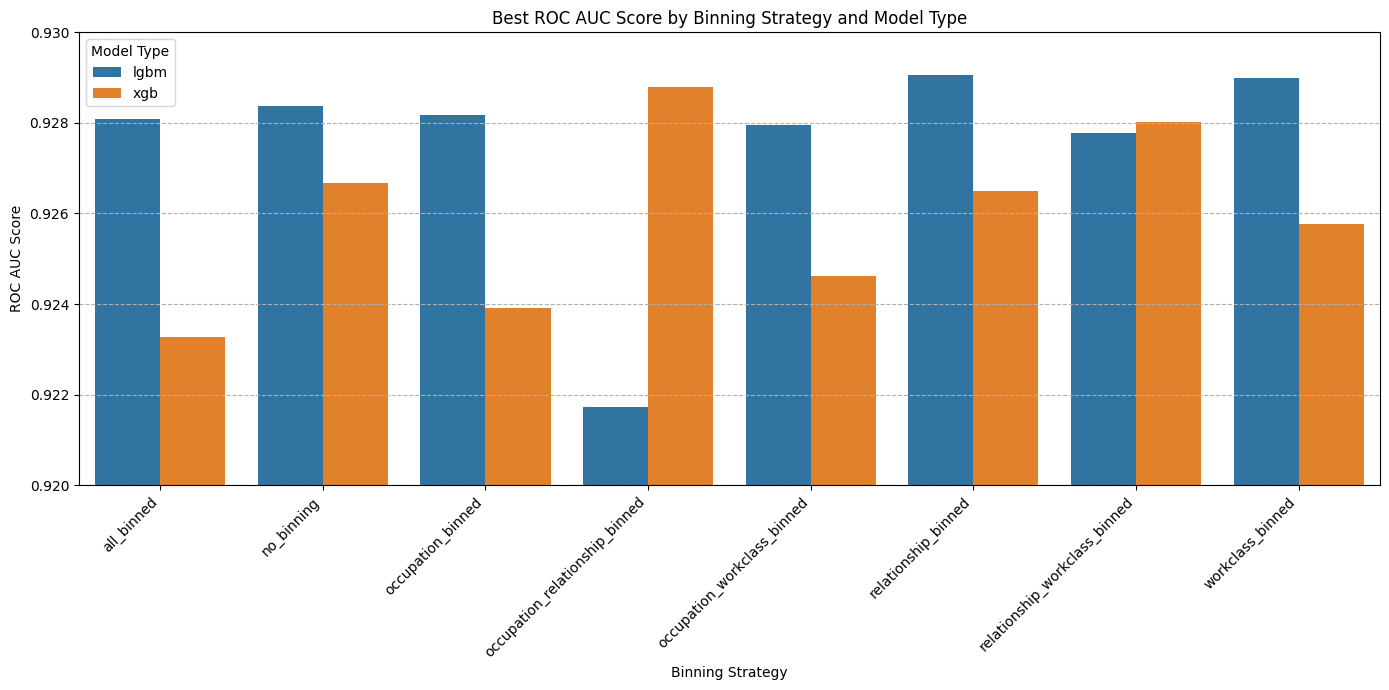

Grouped bar chart visualizing best ROC AUC scores generated successfully.


In [18]:
plt.figure(figsize=(14, 7))
sns.barplot(data=best_scores_df, x='combo_name', y='roc_auc_score', hue='model_type')
plt.title('Best ROC AUC Score by Binning Strategy and Model Type')
plt.xlabel('Binning Strategy')
plt.ylabel('ROC AUC Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')

# Set the y-axis limits
plt.ylim(0.92, 0.93)

plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print("Grouped bar chart visualizing best ROC AUC scores generated successfully.")

Contents of results_df (first 5 rows):

   combo_name model_type  roc_auc_score  \
0  no_binning        xgb       0.901608   
1  no_binning        xgb       0.905762   
2  no_binning        xgb       0.924058   
3  no_binning        xgb       0.924562   
4  no_binning        xgb       0.926670   

                                     hyperparameters  
0  {'model_type': 'xgb', 'xgb_max_depth': 3, 'xgb...  
1  {'model_type': 'xgb', 'xgb_max_depth': 5, 'xgb...  
2  {'model_type': 'xgb', 'xgb_max_depth': 11, 'xg...  
3  {'model_type': 'xgb', 'xgb_max_depth': 16, 'xg...  
4  {'model_type': 'xgb', 'xgb_max_depth': 7, 'xgb...  

ROC AUC score distribution across all trials:

count    200.000000
mean       0.921598
std        0.007733
min        0.891626
25%        0.916996
50%        0.924887
75%        0.927471
max        0.929048
Name: roc_auc_score, dtype: float64


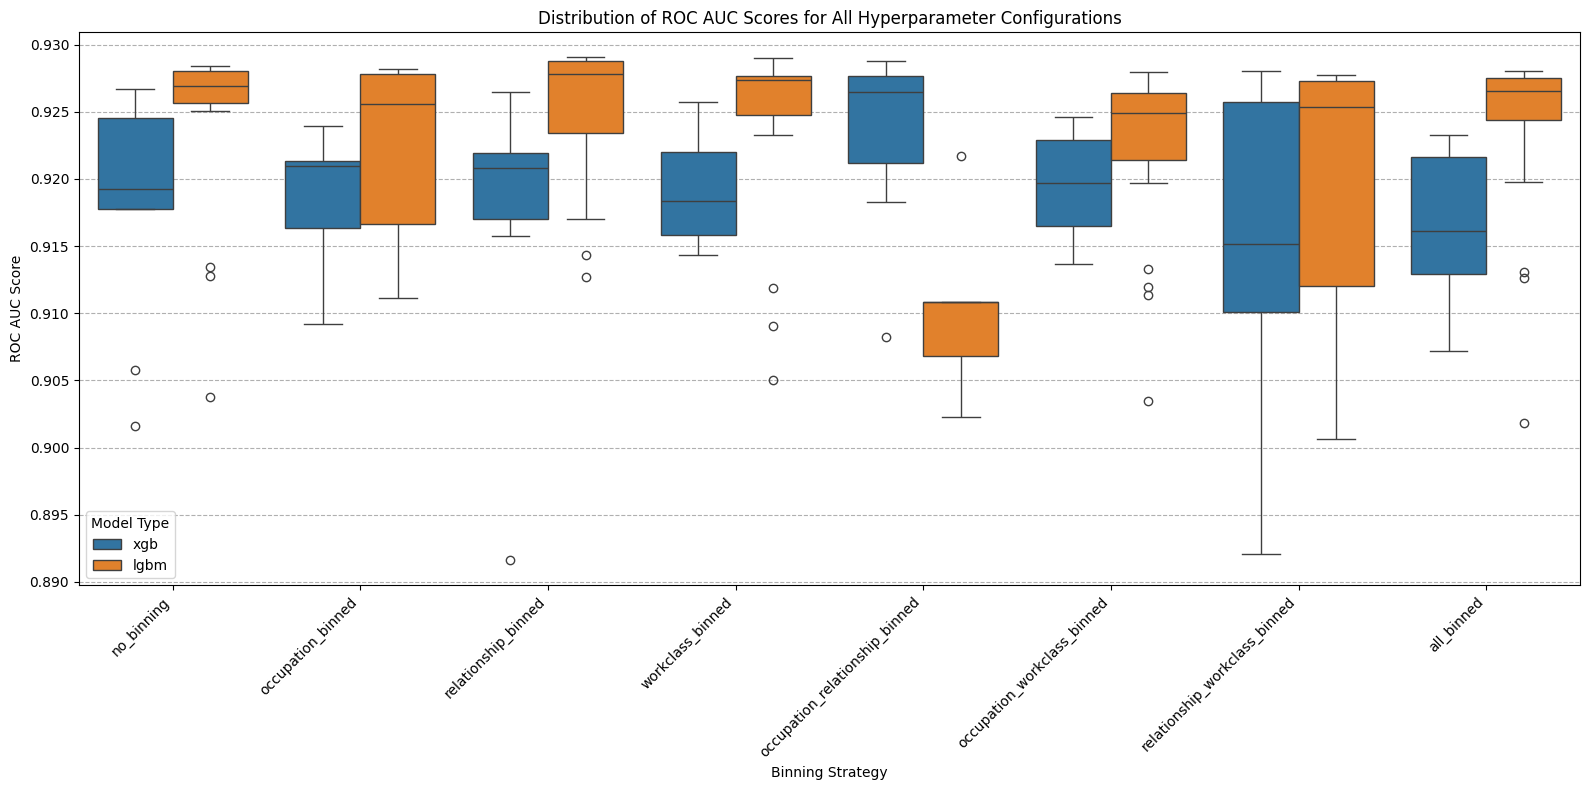

Box plot showing ROC AUC score distribution for all trials generated successfully.


In [19]:
# Display the first few rows of the DataFrame containing all trial results
print("Contents of results_df (first 5 rows):\n")
print(results_df.head())

# Display basic statistics of ROC AUC scores across all trials
print("\nROC AUC score distribution across all trials:\n")
print(results_df['roc_auc_score'].describe())

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of ROC AUC scores for all trials
plt.figure(figsize=(16, 8))
sns.boxplot(data=results_df, x='combo_name', y='roc_auc_score', hue='model_type')
plt.title('Distribution of ROC AUC Scores for All Hyperparameter Configurations')
plt.xlabel('Binning Strategy')
plt.ylabel('ROC AUC Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print("Box plot showing ROC AUC score distribution for all trials generated successfully.")

In [21]:
# results_df has columns: combo_name, model_type, roc_auc_score, hyperparameters

# Get the index of the best trial (highest ROC AUC) for each (combo_name, model_type)
best_idx = results_df.groupby(['combo_name', 'model_type'])['roc_auc_score'].idxmax()

# DataFrame of best hyperparameter sets per combo + model
winners_df = results_df.loc[best_idx].reset_index(drop=True)

print("Best trial per (binning combo, model type):")
print(winners_df[['combo_name', 'model_type', 'roc_auc_score']])


Best trial per (binning combo, model type):
                        combo_name model_type  roc_auc_score
0                       all_binned       lgbm       0.928076
1                       all_binned        xgb       0.923270
2                       no_binning       lgbm       0.928376
3                       no_binning        xgb       0.926670
4                occupation_binned       lgbm       0.928169
5                occupation_binned        xgb       0.923913
6   occupation_relationship_binned       lgbm       0.921723
7   occupation_relationship_binned        xgb       0.928790
8      occupation_workclass_binned       lgbm       0.927946
9      occupation_workclass_binned        xgb       0.924621
10             relationship_binned       lgbm       0.929048
11             relationship_binned        xgb       0.926500
12   relationship_workclass_binned       lgbm       0.927768
13   relationship_workclass_binned        xgb       0.928026
14                workclass_binned       

In [22]:
eval_rows = []
roc_curves = {}
pr_curves = {}

for _, row in winners_df.iterrows():
    combo_name = row['combo_name']
    model_type = row['model_type']
    params = row['hyperparameters']

    print(f"\n=== Evaluating best {model_type} for combo '{combo_name}' ===")

    # Load X for this binning combo
    X_train_combo, X_test_combo = load_combo(combo_name)

    # Build preprocessor for these features
    preprocessor = make_preprocessor(X_train_combo.columns)

    # Recreate the best model using FixedTrial with the stored params
    fixed_trial = optuna.trial.FixedTrial(params)
    model = create_model(fixed_trial, model_type)

    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model),
    ])

    # Fit on the full training set for this combo
    pipe.fit(X_train_combo, y_train)

    # Predict on held-out test set
    y_proba = pipe.predict_proba(X_test_combo)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # Compute metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    ll = log_loss(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)

    eval_rows.append({
        "combo_name": combo_name,
        "model_type": model_type,
        "roc_auc": roc_auc,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "log_loss": ll,
        "avg_precision": avg_prec,
    })

    # Store curves for plotting later
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)

    roc_curves[(combo_name, model_type)] = (fpr, tpr)
    pr_curves[(combo_name, model_type)] = (rec_curve, prec_curve)

# Collect metrics into a DataFrame and sort by ROC AUC
eval_df = pd.DataFrame(eval_rows).sort_values("roc_auc", ascending=False).reset_index(drop=True)

print("\nEvaluation metrics for best models per combo + model:")
print(eval_df)



=== Evaluating best lgbm for combo 'all_binned' ===
[LightGBM] [Info] Number of positive: 9349, number of negative: 29724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 39073, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239270 -> initscore=-1.156685
[LightGBM] [Info] Start training from score -1.156685


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Evaluating best xgb for combo 'all_binned' ===

=== Evaluating best lgbm for combo 'no_binning' ===
[LightGBM] [Info] Number of positive: 9349, number of negative: 29724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 427
[LightGBM] [Info] Number of data points in the train set: 39073, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239270 -> initscore=-1.156685
[LightGBM] [Info] Start training from score -1.156685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Evaluating best xgb for combo 'no_binning' ===

=== Evaluating best lgbm for combo 'occupation_binned' ===
[LightGBM] [Info] Number of positive: 9349, number of negative: 29724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 39073, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239270 -> initscore=-1.156685
[LightGBM] [Info] Start training from score -1.156685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Evaluating best xgb for combo 'occupation_binned' ===

=== Evaluating best lgbm for combo 'occupation_relationship_binned' ===
[LightGBM] [Info] Number of positive: 9349, number of negative: 29724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 39073, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239270 -> initscore=-1.156685
[LightGBM] [Info] Start training from score -1.156685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Evaluating best xgb for combo 'occupation_relationship_binned' ===

=== Evaluating best lgbm for combo 'occupation_workclass_binned' ===
[LightGBM] [Info] Number of positive: 9349, number of negative: 29724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 39073, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239270 -> initscore=-1.156685
[LightGBM] [Info] Start training from score -1.156685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Evaluating best xgb for combo 'occupation_workclass_binned' ===

=== Evaluating best lgbm for combo 'relationship_binned' ===
[LightGBM] [Info] Number of positive: 9349, number of negative: 29724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 425
[LightGBM] [Info] Number of data points in the train set: 39073, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239270 -> initscore=-1.156685
[LightGBM] [Info] Start training from score -1.156685


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Evaluating best xgb for combo 'relationship_binned' ===

=== Evaluating best lgbm for combo 'relationship_workclass_binned' ===
[LightGBM] [Info] Number of positive: 9349, number of negative: 29724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 39073, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239270 -> initscore=-1.156685
[LightGBM] [Info] Start training from score -1.156685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Evaluating best xgb for combo 'relationship_workclass_binned' ===

=== Evaluating best lgbm for combo 'workclass_binned' ===
[LightGBM] [Info] Number of positive: 9349, number of negative: 29724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 425
[LightGBM] [Info] Number of data points in the train set: 39073, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239270 -> initscore=-1.156685
[LightGBM] [Info] Start training from score -1.156685


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Evaluating best xgb for combo 'workclass_binned' ===

Evaluation metrics for best models per combo + model:
                        combo_name model_type   roc_auc  accuracy  precision  \
0   occupation_relationship_binned        xgb  0.931574  0.875525   0.790072   
1              relationship_binned       lgbm  0.931291  0.876651   0.786545   
2                 workclass_binned       lgbm  0.931139  0.874808   0.784875   
3                       all_binned       lgbm  0.930668  0.873682   0.783077   
4    relationship_workclass_binned        xgb  0.930628  0.875934   0.790806   
5                occupation_binned       lgbm  0.930545  0.875525   0.790072   
6                       no_binning       lgbm  0.929867  0.876139   0.785137   
7    relationship_workclass_binned       lgbm  0.929685  0.875934   0.787538   
8      occupation_workclass_binned       lgbm  0.929671  0.874603   0.783495   
9              relationship_binned        xgb  0.929445  0.875320   0.781974   
10     

In [23]:
best_model_row = eval_df.iloc[0]

print("\n==============================")
print("Overall best model on TEST SET")
print("==============================")
print(best_model_row)

print(f"\nBest model details:\n"
      f"  Binning combo : {best_model_row['combo_name']}\n"
      f"  Model type    : {best_model_row['model_type']}\n"
      f"  ROC AUC       : {best_model_row['roc_auc']:.4f}\n"
      f"  Accuracy      : {best_model_row['accuracy']:.4f}\n"
      f"  Precision     : {best_model_row['precision']:.4f}\n"
      f"  Recall        : {best_model_row['recall']:.4f}\n"
      f"  F1            : {best_model_row['f1']:.4f}\n"
      f"  Avg Precision : {best_model_row['avg_precision']:.4f}\n"
      f"  Log Loss      : {best_model_row['log_loss']:.4f}")



Overall best model on TEST SET
combo_name       occupation_relationship_binned
model_type                                  xgb
roc_auc                                0.931574
accuracy                               0.875525
precision                              0.790072
recall                                  0.65355
f1                                     0.715356
log_loss                               0.270075
avg_precision                          0.836512
Name: 0, dtype: object

Best model details:
  Binning combo : occupation_relationship_binned
  Model type    : xgb
  ROC AUC       : 0.9316
  Accuracy      : 0.8755
  Precision     : 0.7901
  Recall        : 0.6536
  F1            : 0.7154
  Avg Precision : 0.8365
  Log Loss      : 0.2701


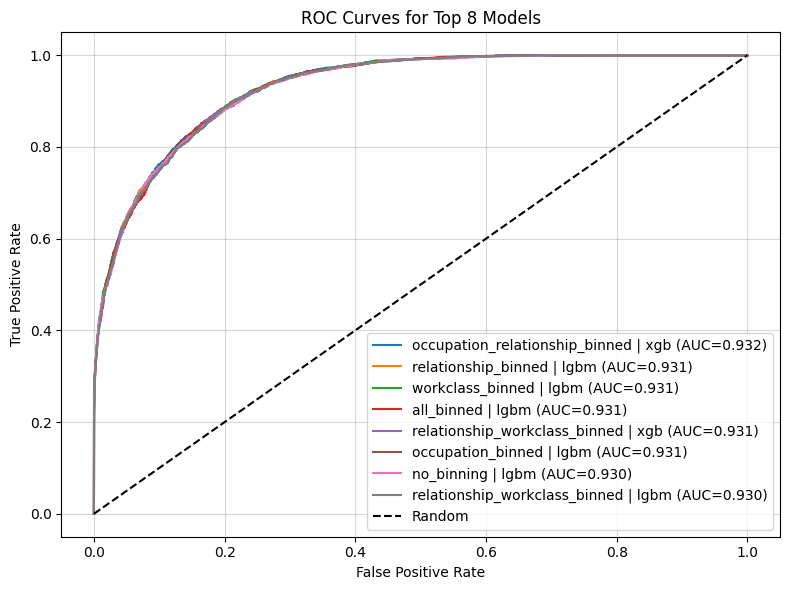

In [27]:
# How many top models to show (to keep curves readable)
TOP_K = 8

top_models = eval_df.head(TOP_K)

plt.figure(figsize=(8, 6))
for _, row in top_models.iterrows():
    key = (row["combo_name"], row["model_type"])
    fpr, tpr = roc_curves[key]
    plt.plot(
        fpr,
        tpr,
        label=f"{row['combo_name']} | {row['model_type']} (AUC={row['roc_auc']:.3f})"
    )

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title(f"ROC Curves for Top {TOP_K} Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


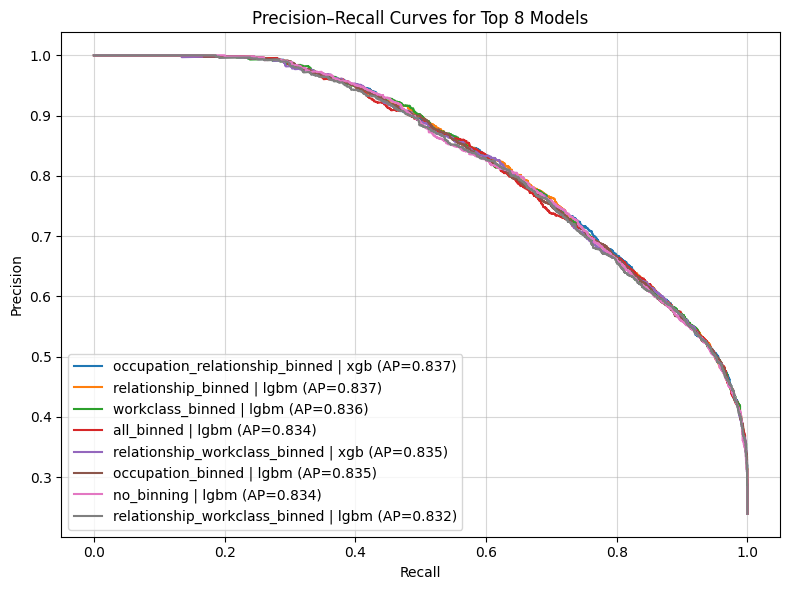

In [28]:
plt.figure(figsize=(8, 6))
for _, row in top_models.iterrows():
    key = (row["combo_name"], row["model_type"])
    rec_curve, prec_curve = pr_curves[key]
    plt.plot(
        rec_curve,
        prec_curve,
        label=f"{row['combo_name']} | {row['model_type']} (AP={row['avg_precision']:.3f})"
    )

plt.title(f"Precision–Recall Curves for Top {TOP_K} Models")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()
